In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as sps
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
import seaborn as sns
import os
from typing import List

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cuda:0


In [3]:

class FeedbackDataset:
    def __init__(self, feedback: pd.DataFrame, user_info: pd.DataFrame, item_info: pd.DataFrame):
        self.feedback = feedback
        self.user_info = user_info
        self.item_info = item_info

    def __getitem__(self, idx: int):
        deal = self.feedback.iloc[idx]
        user_features = self.user_info.loc[self.user_info.UserId == deal['UserId']].drop('UserId', axis=1).to_numpy()
        item_features = self.item_info.loc[self.item_info.ItemId == deal['ItemId']].drop('ItemId', axis=1).to_numpy()
        feedback = deal["Feedback"]
        return np.hstack([user_features, item_features])[0], feedback

    def __len__(self) -> int:
        return self.feedback.shape[0]

In [14]:
def usefulness(c, w, noice):
    return np.arctan(c - w + noice) / np.pi + 0.5


customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)


class Distribution_Handler:
    def __init__(self, distribution):
        self.distribution = distribution

    def rvs(self, size=1):
        if issubclass(type(self.distribution), sps.rv_continuous):
            return self.distribution.rvs(size)
        else:
            return self.distribution.resample(size)[0]

In [149]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape=2, num_classes=2):
        super(self.__class__, self).__init__()
        self.ratings = []
        self.model = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(256, 32),
            nn.Sigmoid(),
            nn.Linear(32, num_classes),
            nn.Sigmoid(),
        )

    def get_interacted_items(self, user_id):
        return self.ratings.loc[self.ratings.UserId == user_id]['ItemId'].unique()

    def recommend_topN(self, user_info, items_to_recommend, topn=10):
        with torch.no_grad():
            n = min(topn, len(items_to_recommend.index))
            features = items_to_recommend["F"].to_numpy()
            x = np.vstack((np.array([user_info["F"]] * len(features)), features)).T
            x = (torch.from_numpy(x)).type(torch.FloatTensor).to(device)
            y_pred = self.__call__(x)[:, 1]
            
            res = torch.topk(y_pred, k=n)
            return pd.DataFrame({"ItemId": res.indices.cpu().numpy(), "Rating": res.values.cpu().numpy()})

    def forward(self, inp):
        out = self.model(inp)
        return out

In [150]:
def fit_epoch(model, optimizer, loss_function, loader):
    model.train()
    processed_size = 0
    cumulative_loss = 0.0
    correct = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.type(torch.FloatTensor).to(device)
        y_batch = y_batch.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()

        y_pred = model(x_batch)
        loss = loss_function.forward(y_pred[:, 1], y_batch)
        loss.backward()

        optimizer.step()
        cumulative_loss += loss
        processed_size += x_batch.shape[0]
        correct += torch.sum(torch.argmax(y_pred, dim=1) == y_batch)

    return cumulative_loss.item() / processed_size, correct.item() / processed_size

In [181]:
def eval_epoch(model, loss_function, loader):
    model.eval()
    processed_size = 0
    cumulative_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(torch.FloatTensor).to(device)
            y_batch = y_batch.type(torch.FloatTensor).to(device)
            
            y_pred = model(x_batch)
            loss = loss_function.forward(y_pred[:,1], y_batch)

            cumulative_loss += loss
            processed_size += len(x_batch)
            correct += torch.sum(torch.argmax(y_pred, dim=1) == y_batch)

    return cumulative_loss.item() / processed_size, correct.item() / processed_size

In [182]:
# model = NeuralNetwork().to(device)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
# loss_func = torch.nn.BCELoss()
# n_epoch = 10
# loss_history = []
# accuracy_history = []
# for epoch in range(n_epoch):
#     train_loss_and_accuracy = fit_epoch(model, opt, loss_func, train_data_loader)
#     # validation_loss_and_accuracy = eval_epoch(model, loss_func, val_loader)
#     loss_history.append(train_loss_and_accuracy[0])
#     accuracy_history.append(train_loss_and_accuracy[1])
# 
#     print(f"Train loss: {loss_history[-1]}")
#     print(f"Train accuracy: {accuracy_history[-1]}")

In [183]:
def print_distributions(num_of_iteration, axs, user_info, item_info):
    sns.kdeplot(user_info["F"], ax=axs[0], label=f"Itration number = {num_of_iteration}")
    axs[0].set_title("User Distribution")
    sns.kdeplot(data=item_info["F"], ax=axs[1])
    axs[1].set_title("Item Distribution")

In [192]:
def dynamic_system_iterate(model, loss_function, optimizer, customer_distribution, w_distribution, c_size=8, w_size=8, num_of_steps=5, topn=5,
                           delta=1e-4):
    user_info = pd.DataFrame(
        {"F": customer_distribution.rvs(size=c_size)})  # size = (c_size, c_feature_size) в многомерном случае 
    user_info["UserId"] = np.arange(c_size)

    item_info = pd.DataFrame(
        {"F": w_distribution.rvs(size=w_size)})  # size = (w_size, w_feature_size) в многомерном случае 
    item_info["ItemId"] = np.arange(w_size)

    predicted_feedback = []
    real_feedback = []
    
    for step in range(1, num_of_steps + 1):
        for index, user_row in user_info.iterrows():
            w_offered = model.recommend_topN(user_row, item_info, topn=topn)
            for _, w in w_offered.iterrows():
                # print(w)
                feature = item_info.loc[item_info.ItemId == w.ItemId]["F"]
                real_deal = sps.bernoulli.rvs(usefulness(user_row["F"], feature, epsilon.rvs()))  # моделируем сделки
                real_feedback.append((user_row["UserId"], w["ItemId"], real_deal))
                
                predicted_deal =  sps.bernoulli.rvs(w["Rating"])
                predicted_feedback.append((user_row["UserId"], w["ItemId"], predicted_deal))
    # print(real_feedback)
    new_feedback_df = pd.DataFrame(real_feedback, columns=['UserId', 'ItemId', 'Feedback'])    
    
    # print(new_feedback_df)
    batch_size = 128
    train_dataset = FeedbackDataset(new_feedback_df, user_info, item_info)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    loss, accuracy = eval_epoch(model, loss_function, train_data_loader)
    fit_epoch(model, optimizer, loss_function, train_data_loader)
    
    grouped_users = new_feedback_df.groupby('UserId')['Feedback'].mean().reset_index()
    grouped_users['Feedback'] += delta

    user_info = user_info.merge(grouped_users, how="inner", on='UserId')
    customer_distribution = Distribution_Handler(
        sps.gaussian_kde(user_info["F"], bw_method=.105, weights=user_info['Feedback']))
    grouped_items = new_feedback_df.groupby('ItemId')['Feedback'].mean().reset_index()

    item_info = item_info.merge(grouped_items, how="left", on='ItemId').fillna(0)
    item_info['Feedback'] += delta

    w_distribution = Distribution_Handler(
        sps.gaussian_kde(item_info["F"], bw_method=.09, weights=item_info['Feedback']))

    return customer_distribution, w_distribution, loss



In [208]:
start_c_size = 128
start_w_size = 128

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=start_c_size)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(start_c_size)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=start_w_size)})
item_info["ItemId"] = np.arange(start_w_size)
feedback = []

# print_distributions(0, axs,user_info, item_info)

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))
feedback = pd.DataFrame(feedback, columns=['UserId', 'ItemId', 'Feedback'])
batch_size = 512
train_dataset = FeedbackDataset(feedback, user_info, item_info)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [209]:
model = NeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
loss_func = torch.nn.BCELoss()
loss_history = []
# accuracy_history = []
loss, _ = fit_epoch(model, opt, loss_func, train_data_loader)
# loss_history.append(loss)

In [210]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution
c_size = 128
w_size = 256
big_steps = 200
for i in tqdm(range(big_steps)):
    if i % 5 == 0:
        new_cust_distr, new_w_distr, loss = dynamic_system_iterate(model, loss_func, opt, new_cust_distr, new_w_distr,
                                                                                c_size=c_size,
                                                                                w_size=w_size, num_of_steps=1)
        # plt.figure(figsize=(7, 7))
        # plt.hist(current_metr_distr["Feedback"], density=True)
    else:
        new_cust_distr, new_w_distr, loss = dynamic_system_iterate(model, loss_func, opt, new_cust_distr, new_w_distr,
                                                                                 c_size=c_size,
                                                                                 w_size=w_size, num_of_steps=1)
    loss_history.append(loss)


100%|██████████| 200/200 [03:30<00:00,  1.05s/it]


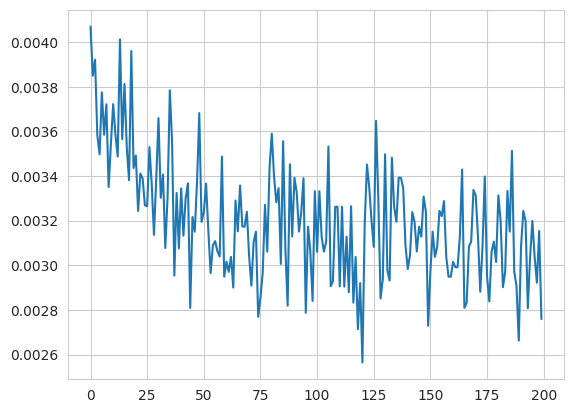

In [212]:
plt.plot(np.arange(big_steps), loss_history)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:

a = np.array([1, 2, 3])
b = np.array([5] * len(a))
a, b

In [343]:
tmp = np.vstack((b, a)).T

In [ ]:
t = torch.from_numpy(tmp)